# CNNでMNISTやってみる
MNISTのタスクをCNNでやってみる


In [1]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L

In [4]:
import pickle, gzip
f = gzip.open('../data/mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
print(len(train_set[0]), len(valid_set[0]), len(test_set[0]))
train_set_x, train_set_y  = train_set
test_set_x, test_set_y = test_set
print(len(train_set_x[0]))
print(train_set_x)
print("28x28の画像のモノクロ(白0→黒1)が１次元配列で入っている",train_set_x[:5])
print("最初のラベルは",train_set_y[0])

# あとで、softmax_cross_entropyを使うときに型の判定があり、np.int32じゃないといけない
train_set_y = train_set_y.astype(np.int32)
test_set_y = test_set_y.astype(np.int32)
print(train_set_y )
f.close()

50000 10000 10000
784
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
28x28の画像のモノクロ(白0→黒1)が１次元配列で入っている [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
最初のラベルは 5
[5 0 4 ..., 8 4 8]


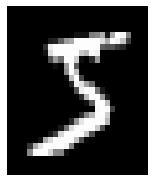

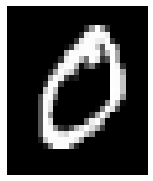

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
def draw_digit(data, size=28):
    plt.figure(figsize=(2.5, 3))
    X, Y = np.meshgrid(range(size),range(size))
    Z = data.reshape(size,size)   # convert from vector to 28x28 matrix
    Z = Z[::-1,:]             # flip vertical
    plt.xlim(0,size-1)
    plt.ylim(0,size-1)
    plt.pcolor(X, Y, Z)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")

    plt.show()

draw_digit(train_set_x[0])
draw_digit(train_set_x[1])

In [19]:
class CNNMNIST(Chain):
    def __init__(self):
        super(CNNMNIST, self).__init__(
            conv1=L.Convolution2D(1,20, 5),
            conv2=L.Convolution2D(20,50, 5),
            l1 = L.Linear(800, 500),
            l2 = L.Linear(500, 10)
        )
        
    def __call__(self, x):
        c1 = F.max_pooling_2d(F.relu(self.conv1(x)),  2)
        c2 = F.max_pooling_2d(F.relu(self.conv2(c1)),  2)
        h1 = F.relu(self.l1(c2))
        return self.l2(h1)

In [20]:
model = L.Classifier(CNNMNIST())

In [22]:
optimizer = optimizers.Adam()
optimizer.setup(model)

batch_size = 100
for step in range(1001):
    batch_index = np.random.randint(len(train_set[0])-batch_size)
    batch_x = train_set_x[batch_index:batch_index+batch_size]
    batch_x = Variable(batch_x.reshape((len(batch_x), 1, 28, 28)))
    batch_y = Variable(train_set_y[batch_index:batch_index+batch_size])
    optimizer.update(model, batch_x, batch_y)
    if step % 100 == 0:
        print(step, model.accuracy.data)

0 0.10999999940395355
100 0.9599999785423279
200 0.9599999785423279
300 0.9900000095367432
400 0.9700000286102295
500 0.9900000095367432
600 0.9700000286102295
700 0.949999988079071
800 1.0
900 0.9900000095367432
1000 1.0


In [24]:
test_set_x = test_set_x.reshape((len(test_set_x), 1, 28, 28))
model(Variable(test_set_x),Variable(test_set_y))
print("精度 →",model.accuracy.data)

精度 → 0.9851999878883362
